In [1]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# some helper functions
def gather_all(data_set_list, column):
    """gather all non-NaN entries from train and data set over a given column."""
    all_values = []
    for data in data_set_list:
        all_values.extend(data[column][data[column].notna()].values)
    return all_values

def compare_accuracy(model, X_train, y_train, X_val, y_val):
    print(f"Accuracy on train data: {round(model.score(X_train, y_train), 2)}")
    print(f"Accuracy on validation data: {round(model.score(X_val, y_val), 2)}")

In [3]:
rng = np.random.default_rng(seed=42)

# Hands-on Machine Learning - Surviving the Titanic
In this exercise we are going to have a (very brief) look at a typical supervised machine learning workflow (or data science workflow). In contrast to all topics we discussed earlier in this course machine learning is a technique that at its core concerns itself with **learning functions from data**. For this reason we usually can't just "run the algorithm" but we need to deal with the data first, which usually takes up most time of any machine learning workflow. Typically, this includes data collection, data cleaning, data preprocessing, and data engineering among other steps. Since this course focuses on algorithms used in AI, however, we will not cover these topics here and only briefly address some issues relevant to this data set that cannot be avoided.

## Titanic Data
In this exercise we are going to have a look at the titanic data set from [Kaggle](https://www.kaggle.com). Kaggle is a website that hosts data science and machine learning competitions and the [Titanic Competition](https://www.kaggle.com/competitions/titanic/overview) provides a good introduction to using supervised learning methods for making data driven predictions. The data can be downloaded from the [kaggle page](https://www.kaggle.com/competitions/titanic/data). The task of this data set is to train a machine learning algorithm that can predict whether a passenger survived the sinking of the titanic. The data comes in tabular form, meaning every row is a new data point (also known as a sample) and each data point has several features (i.e., the columns). The features of this data set are:
- `PassengerId`: an ID given to each passenger.
- `Pclass`: the passenger/ticket class the passenger had, this is a proxy for the persons socio-economic status.
- `Name`: the name of the passenger.
- `Sex`: the sex of the passenger.
- `Age`: the age of the passenger.
- `SibSp`: the number of (sib)lings or (sp)ouses that were on board as well.
- `Parch`: the number of (par)ents or (ch)ildren that were on board as well.
- `Ticket`: the ticket number.
- `Fare`: the ticket fare, i.e. price.
- `Cabin`: the cabin number of the passenger.
- `Embarked`: a letter that indicates which port the passenger embarked from.
As a label (or target variable) we have the variable `Survived`, a binary variable which indicates a passenger that survived with 1, and 0 otherwise.

You can see excerpts of the train data and test data below.

In [4]:
# load data
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")
all_data_sets = [train_df, test_df]
all_data_sets_names = ["Train Data", "Test Data"]

In [5]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Exploratory Data Analysis (EDA)
First we want to look at the data to get a feel for it and see if there are things we need to adjust (e.g. handle missing values) or if there are features we can exploit (e.g. we might be able to extract new information (aka feature engineering) from other features that can help the supervised learning algorithm). 

For the sake of simplicity we omit any feature engineering, extensive background research, or elaborate feature specific handling of missing values here. In practice we would ideally go over every feature one at a time and create plots to check for irregularities (e.g. outliers), missing data, or learn more about what these features mean and potentially engineer new features that might be relevant for the classifier (e.g., the feature `Name` contains information about the title of the passenger which might be an indicator of their social or socio-economic status.)

For the interested we can recommend reading through [this](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8) or [this](https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280) article, which give an overview and starting point on how this process can look. However, this goes far beyond the scope of this lecture.

In [7]:
for i, data in enumerate(all_data_sets):
    print(f"number of samples in {all_data_sets_names[i]}: {data.shape[0]}")
    print(f"number of features in {all_data_sets_names[i]}: {data.shape[1]}\n")

number of samples in Train Data: 891
number of features in Train Data: 12

number of samples in Test Data: 418
number of features in Test Data: 11



We have one more column in the training data than in the test data, this is because our target variable `Survived`, which presents the ground truth label for our supervised learning model to train from, is still part of the training data. We separate this column later.

## Data Preprocessing
### Missing Values
The data is already very clean out of the box, but there are some things we need to address, namely, missing values in the train and test data. Missing values are indicated in the data itself as "NaN" which stands for "Not a Number". Throughout the following steps we will try to keep it as simple as possible, since many more elaborate techniques surpass the topics of this course. For those interested, you can have a look at [this article](https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280), to get a starting point for possible improvements. The [discussion section](https://www.kaggle.com/competitions/titanic/discussion) of the Kaggle competition page is another valuable resource for anyone looking into more advanced techniques, these are however not required for this exercise.

In [8]:
for i, data in enumerate(all_data_sets):
    print(f"Number of missing values per feature ({all_data_sets_names[i]}):")
    print(data.isna().sum(axis=0))
    print("\n")

Number of missing values per feature (Train Data):
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Number of missing values per feature (Test Data):
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64




We see that `Age`, `Cabin`, `Fare`, and `Embarked` contain missing values. Since `Embarked` contains only 2 missing values we can fill this with the most prominent group (keep in mind there are more elaborate ways of dealing with these values) which is "S" as we can see from the histogram below (note that the bars overlap and don't stack). We can also fill the only missing value for `Fare` with the median of all fares in the train and test data.

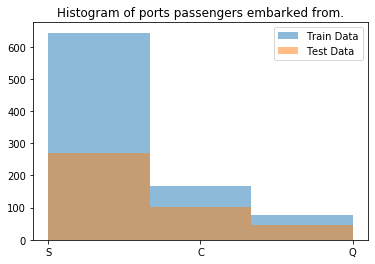

In [9]:
for i, data in enumerate(all_data_sets):
    plt.hist(data["Embarked"][data["Embarked"].notna()], bins=3, alpha=.5, label=all_data_sets_names[i])
plt.legend()
plt.title("Histogram of ports passengers embarked from.");

In [10]:
# filling missing values for embarked with "S"
train_df["Embarked"].fillna("S", inplace=True)

In [11]:
# filling the missing fare value with the median of all fare values
median_fare = np.median(gather_all(all_data_sets, "Fare"))
test_df["Fare"].fillna(median_fare, inplace=True)

For the age it gets a bit trickier as there are many missing values, but to keep things simple we replace the missing values with other values that we have, i.e., we sample uniformly from the age distribution.

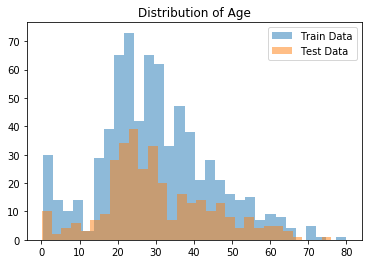

In [12]:
for i, data in enumerate(all_data_sets):
    plt.hist(data["Age"][data["Age"].notna()], alpha=.5, bins=30, label=all_data_sets_names[i])
plt.legend()
plt.title("Distribution of Age");

In [13]:
# gather all ages
all_ages = gather_all(all_data_sets, "Age")

# for each missing value sample one from the ages in the data
for data in all_data_sets:
    nr_missing_values = data["Age"].isna().sum()
    sampled_ages = rng.choice(all_ages, size=nr_missing_values)

    for i in sampled_ages:
        data["Age"].fillna(i, inplace=True, limit=1)

The way in which we need to handle the cabins is a bit more complicated. We could simply remove this feature for simplicity, but since we hope to find some predictive power in this feature we are going to extract the first letter of the cabin code, as this encodes the deck on which the cabin was located. Previous work on this data set has shown that this can be a useful predictor. For each missing data we are going to replace it with 0, as later we will convert all data to be numeric. 

In [14]:
all_cabins = gather_all(all_data_sets, "Cabin")
print("All unique cabins in the data:")
print(np.unique(all_cabins))

unique_decks = np.unique([i[0] for i in all_cabins])
print(f"\nunique deck letters: {unique_decks}")

All unique cabins in the data:
['A10' 'A11' 'A14' 'A16' 'A18' 'A19' 'A20' 'A21' 'A23' 'A24' 'A26' 'A29'
 'A31' 'A32' 'A34' 'A36' 'A5' 'A6' 'A7' 'A9' 'B10' 'B101' 'B102' 'B11'
 'B18' 'B19' 'B20' 'B22' 'B24' 'B26' 'B28' 'B3' 'B30' 'B35' 'B36' 'B37'
 'B38' 'B39' 'B4' 'B41' 'B42' 'B45' 'B49' 'B5' 'B50' 'B51 B53 B55'
 'B52 B54 B56' 'B57 B59 B63 B66' 'B58 B60' 'B61' 'B69' 'B71' 'B73' 'B77'
 'B78' 'B79' 'B80' 'B82 B84' 'B86' 'B94' 'B96 B98' 'C101' 'C103' 'C104'
 'C105' 'C106' 'C110' 'C111' 'C116' 'C118' 'C123' 'C124' 'C125' 'C126'
 'C128' 'C130' 'C132' 'C148' 'C2' 'C22 C26' 'C23 C25 C27' 'C28' 'C30'
 'C31' 'C32' 'C39' 'C45' 'C46' 'C47' 'C49' 'C50' 'C51' 'C52' 'C53' 'C54'
 'C55 C57' 'C6' 'C62 C64' 'C65' 'C68' 'C7' 'C70' 'C78' 'C80' 'C82' 'C83'
 'C85' 'C86' 'C87' 'C89' 'C90' 'C91' 'C92' 'C93' 'C95' 'C97' 'C99' 'D'
 'D10 D12' 'D11' 'D15' 'D17' 'D19' 'D20' 'D21' 'D22' 'D26' 'D28' 'D30'
 'D33' 'D34' 'D35' 'D36' 'D37' 'D38' 'D40' 'D43' 'D45' 'D46' 'D47' 'D48'
 'D49' 'D50' 'D56' 'D6' 'D7' 'D9' 'E10'

In [15]:
# create a map that maps all unique deck letters to integers
deck_numeric = {letter:(i+1) for i,letter in enumerate(unique_decks)}
deck_numeric["Z"] = 0

for data in all_data_sets:
    # fill all missing values with a dummy letter "Z"
    data["Cabin"].fillna("Z", inplace=True)
    # introduce new column/feature with information about the deck
    data["Deck"] = data["Cabin"].str[0].map(deck_numeric)
    # remove Cabin column since we don't need it anymore
    data.drop(["Cabin"], axis=1, inplace=True)

If we now again look at the missing data, we can see that we handled all of it.

In [16]:
for i, data in enumerate(all_data_sets):
    print(f"Number of missing values per feature ({all_data_sets_names[i]}):")
    print(data.isna().sum(axis=0))
    print("\n")

Number of missing values per feature (Train Data):
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Deck           0
dtype: int64


Number of missing values per feature (Test Data):
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Deck           0
dtype: int64




### Convert to Numeric
For this step we need to make sure that all data is in numerical form such that the algorithms can handle the data. From the output below we can see that the columns `Name`, `Sex`, `Ticket`, and `Embarked` are of type object, meaning they are strings. Even though the `Name` column contains some useful information like the title of the passenger (e.g. "Dr", "Col", "Mr", "Miss", etc) we will omit this column all together as handling these cases becomes a bit cumbersome. The same goes for the column `Ticket`. We turn the columns `Sex` and `Embarked` into integers, analogously to the letters for the deck (from `Cabin`). Again, we might want to choose to use one-hot encoding represent these features, but this goes beyond the scope of this lecture. 

In [17]:
for i, data in enumerate(all_data_sets):
    print(f"Feature types ({all_data_sets_names[i]}):")
    print(data.dtypes)
    print("\n")

Feature types (Train Data):
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
Deck             int64
dtype: object


Feature types (Test Data):
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
Deck             int64
dtype: object




In [18]:
# drop ticket and name columns
for data in all_data_sets:
    data.drop(["Name", "Ticket"], axis=1, inplace=True)

In [19]:
print(f"unique values for `Sex`: {np.unique(gather_all(all_data_sets, 'Sex'))}")
print(f"unique values for `Embarked`: {np.unique(gather_all(all_data_sets, 'Embarked'))}")

unique values for `Sex`: ['female' 'male']
unique values for `Embarked`: ['C' 'Q' 'S']


In [20]:
sex_numeric = {"female":0, "male":1}
embarked_numeric = {"C":0, "Q":1, "S":2}

# convert sex and embarked into integers
for data in all_data_sets:
    data["Sex"] = data["Sex"].map(sex_numeric)
    data["Embarked"] = data["Embarked"].map(embarked_numeric)

We have now successfully converted all features to numeric values as can be seen from the output below.

In [21]:
for i, data in enumerate(all_data_sets):
    print(f"Feature types ({all_data_sets_names[i]}):")
    print(data.dtypes)
    print("\n")

Feature types (Train Data):
PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
Deck             int64
dtype: object


Feature types (Test Data):
PassengerId      int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
Deck             int64
dtype: object




We are now almost done, we remove the column `PassengerId` since we cannot use this in our models because the passengers in the train dataset are obviously not the same passengers as in the test dataset. Therefore, this column cannot provide any useful information and in the worst case might introduce noise, e.g., if the data is ordered by the `Survived` label and thus create unintentional correlation between this column and the labels. However, we store the ids, so that we can properly create a submission file later.

In [22]:
passenger_ids_test_df = pd.DataFrame(test_df["PassengerId"], columns=["PassengerId"])
for data in all_data_sets:
    data.drop("PassengerId", axis=1, inplace=True)

Our final data now looks as follows:

In [23]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,0,3,1,22.0,1,0,7.2500,2,0
1,1,1,0,38.0,1,0,71.2833,0,3
2,1,3,0,26.0,0,0,7.9250,2,0
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,2,0
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2,0
887,1,1,0,19.0,0,0,30.0000,2,2
888,0,3,0,30.0,1,2,23.4500,2,0
889,1,1,1,26.0,0,0,30.0000,0,3


In [24]:
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,3,1,34.5,0,0,7.8292,1,0
1,3,0,47.0,1,0,7.0000,2,0
2,2,1,62.0,0,0,9.6875,1,0
3,3,1,27.0,0,0,8.6625,2,0
4,3,0,22.0,1,1,12.2875,2,0
...,...,...,...,...,...,...,...,...
413,3,1,28.0,0,0,8.0500,2,0
414,1,0,39.0,0,0,108.9000,0,3
415,3,1,38.5,0,0,7.2500,2,0
416,3,1,27.0,0,0,8.0500,2,0


## Training Machine Learning Models
After this data preprocessing phase we now come to the part where we can train a model. First, however, we need to split our training data into a train set and a validation set. We will train the algorithm on the train set and evaluate its performance on the validation set, because we don't know the true labels for the test set (that is why we want to predict it with the ML algorithm). We can then use the validation set to perform model selection by comparing various algorithms or various hyperparameter combinations for some algorithm.

In typical machine learning fashion we denote the data set with $X$ as it is essentially just a matrix of values. Similarly, we denote the labels as $y$, since they are a vector of values (in our case binary).

In [25]:
y = train_df["Survived"].copy()
X = train_df.drop("Survived", axis=1).copy()
feature_names = train_df.drop("Survived", axis=1).columns
X_test = test_df.copy()

### Train-Validation Split
**Exercise**: Perform a train-validation split from the training data given in `train_df`. You should create a split in which the training data makes up 75% of the dataframe.

In [26]:
# TODO: perform a train validation split using the sklearn function train_test_split()
X_train, X_val, y_train, y_val = 

### Decision Tree
**Exercise**: Train a decision tree using the scikit-learn model `DecisionTreeClassifier`. Make sure to set the criterion to "entropy" in order to use the information gain criterion discussed in the lecture. You are free to use any other hyperparameters you like (e.g., `max_depth`, `max_features`) but we recommend starting with `max_depth=3` as this allows for a readable plot later on, otherwise the tree will grow very large. Also, consider providing a seed via the argument `random_state` in order to guarantee reproducible results.

In [27]:
# TODO: instantiate a decision tree with DecisionTreeClassifier. Make sure to use criterion="entropy"
decision_tree = 

# TODO: train the decision tree on the train data `X_train` and `y_train` using the `fit()` method.


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [28]:
compare_accuracy(decision_tree, X_train, y_train, X_val, y_val)

Accuracy on train data: 0.83
Accuracy on validation data: 0.78


Below we plot the decision tree. At each node we see:
- The feature that gets used to make a decision and the value at which it makes it decision (e.g. `Sex <=0.5` separating the women (`Sex=0`) to the left child and the men (`Sex=1`) to the right child).
- The entropy of the current node and the closer the entropy is to 1 the lighter the color (i.e., the closer to white). 
- The label distribution (`value=[number of samples with y=0, number of samples with y=1]`) and label of the majority of this node (e.g., `class=survived` means that most passengers that fall into this node/category survived). Nodes where the majority survived are colored in blue, the nodes where the majority did not survive are colored in orange.

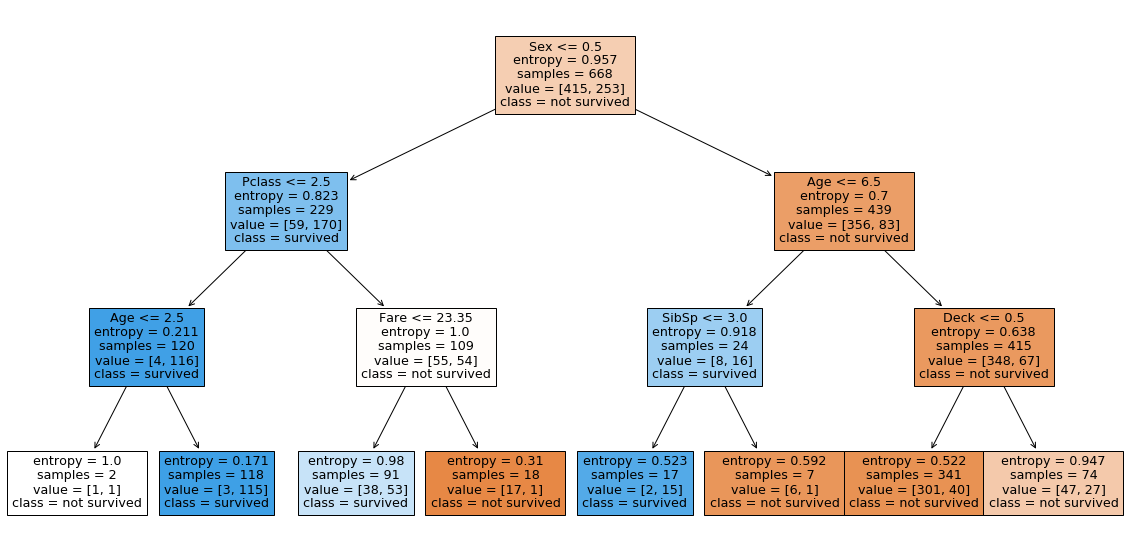

In [29]:
fig = plt.figure(figsize=(20,10))
_ = plot_tree(decision_tree, 
    feature_names=feature_names,  
    class_names=["not survived", "survived"],
    filled=True
)
fig.savefig("decision_tree.pdf")

### Random Forest
**Exercise**: Train a random forest using the scikit-learn model `RandomForestClassifier`. Make sure to set the criterion to "entropy" in order to use the information gain criterion discussed in the lecture. You are free to use any other hyperparameters you like (e.g., `n_estimators`, `max_depth`, `max_features`). We recommend starting with `n_estimators=50` and `max_features=5`. Also, consider providing a seed via the argument `random_state` in order to guarantee reproducible results.

In [41]:
# TODO: instantiate a random forest with RandomForestClassifier. Make sure to use criterion="entropy"
random_forest = 

# TODO: train the random forest on the train data `X_train` and `y_train` using the `fit()` method.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [42]:
compare_accuracy(random_forest, X_train, y_train, X_val, y_val)

Accuracy on train data: 0.85
Accuracy on validation data: 0.8


## Bonus Exercises

### Hyperparameter Selection
One of the most difficult things about using machine learning is finding suitable hyperparameters that perform well but that don't overfit on the train or even validation data. In this exercise you should explore the use of a method called grid search that exhaustively trains models to try out all hyperparameter combinations, given the values you specify. For example, if we have a random forest and the two hyperparameters `n_estimators` = [25, 50, 100] and `max_depth` = [2, 3, 4], then the grid search algorithm would train a separate random forest for all $3^2=9$ combinations, i.e., the grid spanned by the arrays of possible parameter values. This is a very expensive operation, and therefore the provided values should be chosen carefully.

An advanced version of this algorithm is implemented in the scikit-learn function `GridSearchCV` which also handles the validation part for you, i.e., there is no need for separating training and validation data.

**Exercise**: Use the `GridSearchCV` to find good parameters. Note that when its `fit` method you should pass `X` and `y` as it takes care of the validation, so don't just pass `X_train` and `y_train`. We recommend choosing about three parameters with at most three values.

In [35]:
random_forest = RandomForestClassifier(
    random_state=42
)

# TODO: define a grid of parameters as follows: {"parameter1": [val1, val2, val3], "parameter2": [val1, None]}
param_grid = {
}
# TODO: perform grid search with the above parameters and the random forrest classifier and train the models with the fit() method of the grid search object
grid_search = 

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                               

In [36]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Score achieved with best parameters: {round(grid_search.best_score_, 2)}")

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 100}
Score achieved with best parameters: 0.82


In [37]:
best_random_forest = grid_search.best_estimator_

### Submitting a Test Prediction to Kaggle 
**Exercise**: If you wish to test your model against the test set on Kaggle you can do so by submitting the `submission.csv` file that gets created in the cell below. You can choose any model for this, simply pass the selected model as argument into the function `create_sumbission_file()`. This part is completely optional!

**Note**: You will need to create an account in order to log in and if you wish to submit your predictions you will need to verify your account with a phone number. Also note that each participant gets a maximum of 5 submissions per day (in order to make it more difficult to overfit on the test set).

In [38]:
def create_submission_file(model):
    passenger_ids_test_df["Survived"] = model.predict(X_test)
    passenger_ids_test_df.to_csv("submission.csv", index=False)

create_submission_file(best_random_forest)